In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import os 
import sys 

# TODO: remove '..' if run from root folder
home = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
pths = [os.path.join(home, 'astrobot'), os.path.join(home, 'astrobot', 'tests')]

for pth in pths: 
    if pth not in sys.path: sys.path.insert(0, pth)

from astrobot import pmf

import numpy as np 
import pandas as pd
from pprint import pprint 
import matplotlib.pyplot as plt 
from functools import reduce 

def pp(x, *args): 
    pprint(x) if not args else (pprint(x), pp(*args))


In [2]:
# bldg_stock namespace
def get_osm_url(bldg_id, zero_pad=7):
    zeros = reduce(
        lambda a, b: str(a)+"0", range(zero_pad - int(np.log10(bldg_id) + 1)))
    return ("https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/" +  "end-use-load-profiles-for-us-building-stock/2021/" +
            "comstock_tmy3_release_1/building_energy_models/" + 
            "bldg{}-up00.osm.gz".format(zeros + str(bldg_id)))
            
DATADIR = "C:/users/admin/master/astrobot/resources/rescomstock/comstock"
assert os.path.isdir(DATADIR)
metacom_fpath = os.path.join(DATADIR, "metadata_comstock.tsv")
_comdf = pd.read_csv(metacom_fpath, sep='\t')
_comdf = _comdf.dropna(axis=0, how="any")
_comdf.head(2)

,bldg_id,applicability,in.upgrade_name,in.aspect_ratio,in.county,in.building_type,in.rotation,in.number_of_stories,in.sqft,in.hvac_system_type,...,out.electricity.total.energy_consumption_intensity,out.site_energy.total.energy_consumption,out.site_energy.total.energy_consumption_intensity,out.natural_gas.total.energy_consumption,out.natural_gas.total.energy_consumption_intensity,out.other_fuel.total.energy_consumption,out.other_fuel.total.energy_consumption_intensity,upgrade,weight,metadata_index
0,105,True,Baseline,2.0,G0100890,SmallOffice,270.0,1.0,17500.0,PSZ-AC with electric coil,...,8.988889,536.748835,0.030671,0.0,0.0,0.0,0.0,0,7.041741,0
1,170,True,Baseline,3.0,G0100690,SmallOffice,270.0,1.0,3000.0,PSZ-AC with electric coil,...,10.487037,107.349767,0.035783,0.0,0.0,0.0,0.0,0,7.041741,1


In [3]:
def search_comdf_var(var):
    return [col for col in _comdf.columns if var.lower() in col.lower()]

#search_comdf_var("weight")
#set(_comdf["in.building_type"])
#_comdf[["metadata_index", "bldg_id"]]


In [4]:
comdf = _comdf.copy()
# pp([c for c in _comdf.columns if "in." in c])

y_lbls = ["eui"] 
X_lbls = ["cz_cat", "cz", "btype_cat", "btype", "weight", "metadata_index", "bldg_id"] 
comdf[["cz_cat", "btype_cat"]] = comdf[["in.climate_zone_ashrae_2004", "in.building_type"]]
_mbtu_arr, _sqft_arr = \
    comdf["out.site_energy.total.energy_consumption"], comdf["in.sqft"]
comdf[y_lbls[0]] = (_mbtu_arr * 1e6 / 3412) / (_sqft_arr / 10.764)  # Convert MBTU, ft2 -> kWh/m2

# Integer encoding for cz categories
cz_dict = {cz:i for i, cz in enumerate(np.unique(comdf["cz_cat"]))}
comdf["cz"] = [cz_dict[cz] for cz in comdf["cz_cat"]]
 
# Integer encoding for btype
btype_dict = {bt:i for i, bt in enumerate(np.unique(comdf["btype_cat"]))}
comdf["btype"] = [btype_dict[bt] for bt in comdf["btype_cat"]]

comdf = comdf[X_lbls + y_lbls]
comdf.head(3)

,cz_cat,cz,btype_cat,btype,weight,metadata_index,bldg_id,eui
0,3A,3,SmallOffice,12,7.041741,0,105,96.760416
1,3A,3,SmallOffice,12,7.041741,1,170,112.887152
2,3A,3,RetailStripmall,9,1.947971,2,254,455.818507


In [5]:
from tests.pmf_test import test_make_pmf1, test_make_bin_idx, test_make_bin_edges

from scipy.stats._binned_statistic import binned_statistic
pd.set_option("display.precision", 6)

test_make_bin_edges()
test_make_bin_idx()
test_make_pmf1() 


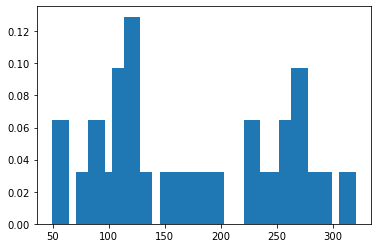

In [6]:
# Joint Pmf
btype = "LargeOffice"
cz = "5B"
data = comdf.query("btype_cat == '{}' & cz_cat == '{}'".format(btype, cz))

eui = pmf.Pmf1(data.eui, data.weight, data.index, bins=25)
eui.df 
pmf.plt_hist(eui, width=15); 



In [90]:
# Coins (independent)
# dataset = pd.DataFrame(
#     {"c1": [0, 1, 0, 1], 
#      "c2": [0, 1, 1, 0]})

# Glued coins (dependant)
dataset = pd.DataFrame(
    {"c1": [0, 1, 0, 1], 
     "c2": [0, 1, 0, 1]})


# def _make_joint_pmf():

var1_states, var2_states = [0, 1], [0, 1]  # bin numbers
v1num, v2num = len(var1_states), len(var2_states)
pxy = np.zeros(shape=(v1num, v2num))

# 1. Possible states as bin num possibilities
states = np.zeros(shape=(v1num, v2num)).tolist()  # outerproduct of states

for i in var1_states: 
    for j in var2_states:
        states[i][j] = (var1_states[i], var2_states[j])

# 2. Check if data1, data2 are in state and return 
# TODO: Rewrite this as bin_edges check: 
# i.e hi, lo = bin_edges[var1_state]; return lo <= var1 < hi
is_intersect_fx = lambda c1, c2, state1, state2: \
    (c1 == state1) and (c2 == state2)


for si in range(2):
    for sj in range(2): 
        c1_state, c2_state = states[si][sj]    
        for i in range(dataset.shape[0]):
            data = dataset.loc[i, :]
            is_intersect = is_intersect_fx(c1_state, c2_state, data.c1, data.c2)
            if is_intersect: 
                pxy[si, sj] = 1

pxy /= np.sum(pxy)
pxy 



array([[1., 0.],
       [0., 0.]])

In [ ]:
# TODO: 
# clean up function: _make_joint_pmf(data) 
# test _make_joint_pmf(data)
# JointPmf(pmf1, pmf2) -> df w/ multiindex
# write: margin_pmf(joint_pmf) -> Pmf
# Rewrite Pmf1 to Pmf
# test p(x, y) = p(x) & p(y) = p(x) p(x|y) = p(y) p(y|x)
# plot joint of eui and cz (same as query)
# write cond_pmf
# p(e,cz,v) = p(e|cz,v) p(cz|v) p(v) 
# Inverse model: 
# p(w|e,cz) = p(w) p(e,cz|w) / p(e,cz)
# pd(wwr|eui) = p(wwr, eui) / p(eui)
# write web app for prediction OR data-exploration

In [ ]:
from scipy.stats import binned_statistic 

# Flip two coins, probability of state = 2^2 = 4 states:
# Joint pmf is:
# [Hx_Hy, Hy_Tx]
# [Tx_Hy, Ty_Tx]
pxy = np.array(
  # y1: H, x2:T
    [[.25, .25],  # x1: H 
     [.25, .25]]) # x2: T
# p(x, y) = p(x) & p(y) = p(x) p(x|y) = p(y) p(y|x) 
# Marginalize ith x row by:
# 1. Summing joint through all j cols 
# 2. Normalize with factor p(x_ij) = 1 / sum_ij( p(x_ij, y_ij))    
# p(x_i=1) = sum_j p(x_i=1, y_j) 
#px = 1 / np.sum([xy_ij for x_i in pxy for xy_ij in x_i])
px_i = np.array([[np.sum(x_i)] for x_i in pxy])
# pp(px_i)
# For py iterate through column space
py_i = np.array([[np.sum(y_j)] for y_j in pxy.T]).T
# pp(py_i)
